In [ ]:
!pip install tensorflow pandas matplotlib numpy scikit-learn

### Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

### Membaca File CSV dan Menampilkan Data Awal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# google drive
df_pidana_umum = pd.read_csv("drive/MyDrive/Colab Notebooks/Dataset_PeduliPasal/dataset_pidana_umum.csv")
df_pidana_khusus = pd.read_csv("drive/MyDrive/Colab Notebooks/Dataset_PeduliPasal/dataset_pidana_khusus.csv")
df = pd.concat([df_pidana_umum, df_pidana_khusus], ignore_index=True)

# local computer
# df_pidana_umum = pd.read_csv("../data/dataset_csv/dataset_pidana_umum.csv")

In [5]:
df_pidana_umum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10729 entries, 0 to 10728
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   amar                10729 non-null  object
 1   amar_lainnya        10729 non-null  object
 2   id                  10729 non-null  object
 3   klasifikasi         10729 non-null  object
 4   lama_hukuman        10729 non-null  int64 
 5   lembaga_peradilan   10729 non-null  object
 6   provinsi            10729 non-null  object
 7   status              10729 non-null  object
 8   sub_klasifikasi     10729 non-null  object
 9   url                 10729 non-null  object
 10  kepala_putusan      10727 non-null  object
 11  identitas           9481 non-null   object
 12  riwayat_penahanan   8830 non-null   object
 13  riwayat_perkara     10630 non-null  object
 14  riwayat_tuntutan    10228 non-null  object
 15  riwayat_dakwaan     10577 non-null  object
 16  fakta               10

In [6]:
# Select relevant features and target
features = ['riwayat_perkara', 'riwayat_tuntutan', 'riwayat_dakwaan', 'amar_putusan', 'fakta']
target = 'sub_klasifikasi'  # Target column for "pasal yang berlaku"

# Drop rows with missing target or all features empty
dataset_cleaned = df_pidana_umum.dropna(subset=features + [target])

# Combine textual features into a single column
dataset_cleaned['combined_text'] = dataset_cleaned[features].fillna('').agg(' '.join, axis=1)

<ipython-input-6-2a67a594ab0a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['combined_text'] = dataset_cleaned[features].fillna('').agg(' '.join, axis=1)


In [7]:
# Prepare input (X) and output (y)
X = dataset_cleaned['combined_text']
y = dataset_cleaned[target]

# Encode the target (sub_classification) into integer classes
sub_classification = y.unique()
class_mapping = {label: idx for idx, label in enumerate(sub_classification)}
y_encoded = y.map(class_mapping)

In [8]:
df_sub_classification = pd.DataFrame(sub_classification)

# if you use local computer
# df_sub_classification.to_csv("../data/dataset_csv/data_classfication.csv", index=False)

# if you use google colab
df_sub_classification.to_csv("drive/MyDrive/Colab Notebooks/Dataset_PeduliPasal/data_classfication.csv", index=False)

In [17]:
# Tokenization and padding
max_words = 50000  # Increase the vocabulary size
max_len = 10000      # Increase the sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Convert the target to categorical (one-hot encoding)
y_categorical = to_categorical(y_encoded)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [19]:
# Build the Sequential model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    BatchNormalization(),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    BatchNormalization(),

    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(sub_classification), activation='softmax')  # Output layer for multi-class classification
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 102s 761ms/step - accuracy: 0.1731 - loss: 2.8114 - val_accuracy: 0.2362 - val_loss: 2.5953
Epoch 2/20
 93/124 ━━━━━━━━━━━━━━━━━━━━ 21s 679ms/step - accuracy: 0.3697 - loss: 2.0055

KeyboardInterrupt: 

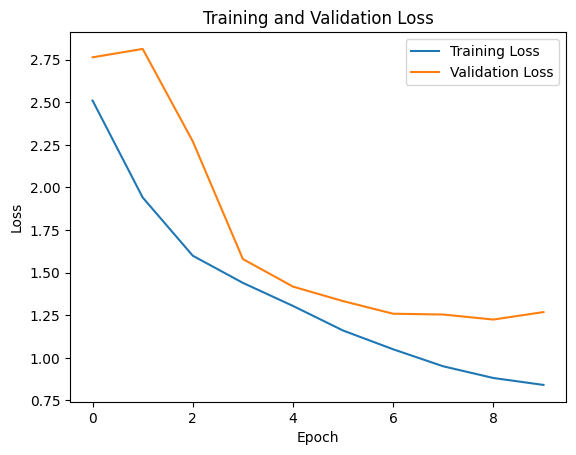

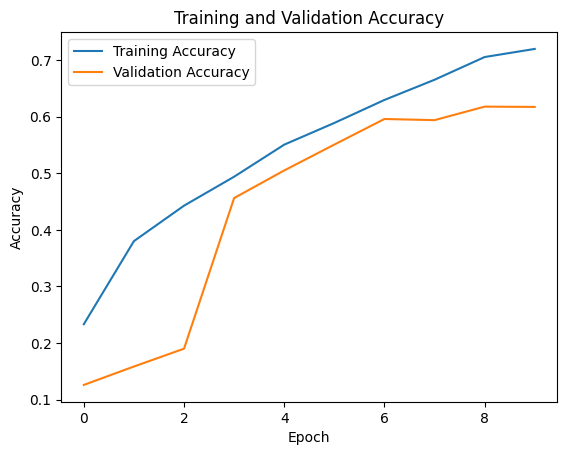

In [14]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2%}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6320 - loss: 1.2267
Test Accuracy: 61.71%


In [ ]:
# Predict on new cases
def predict_pasal(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(input_padded)
    predicted_class = sub_classification[prediction.argmax()]
    return predicted_class

In [ ]:
# Example usage
sample_case = "Kasus pencurian"
predicted_pasal = predict_pasal(sample_case)
print(f"Predicted Pasal: {predicted_pasal}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Predicted Pasal: penipuan


Run this if you want to save the model in the google drive

In [ ]:
with open("drive/MyDrive/Colab Notebooks/Models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

model.save('drive/MyDrive/Colab Notebooks/Models/model_pidana_umum.h5')

Run this if you want to save the model in the local computer

In [ ]:
# with open("../models/tokenizer.pkl", "wb") as f:
#     pickle.dump(tokenizer, f)

# model.save('../models/model_pidana_umum.h5')